In [ ]:
# ============================================================
# 1.6 — VALIDATION PROCEDURES (FIXED & SAFE VERSION)
# Stratified Train/Test Split + Stratified K-Fold Cross-Validation
# ============================================================

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
import numpy as np

# ------------------------------------------------------------
# 1) STRATIFIED TRAIN / TEST SPLIT (KEEP THE ORIGINAL)
# ------------------------------------------------------------
# This is the ONLY split used throughout your entire project.
# DO NOT create a second split.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


# ------------------------------------------------------------
# 2) STRATIFIED K-FOLD CROSS-VALIDATION (K=5)
# ------------------------------------------------------------
# Applied ONLY to the training set — NEVER touch the test set.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    log_reg.named_steps['model'],
    X_train,
    y_train,
    cv=skf,
    scoring=make_scorer(f1_score)
)

print("\nCross-Validation F1-scores:", cv_scores)
print("Mean F1-score:", np.mean(cv_scores))


Train size: 4328
Test size: 1082

Cross-Validation F1-scores: [0.61538462 0.56903766 0.56880734 0.58666667 0.57383966]
Mean F1-score: 0.5827471881703694


To evaluate the model reliably, we use a stratified 80/20 train–test split combined with Stratified 5-Fold Cross-Validation on the training set. A separate validation set is not used because the dataset is already imbalanced and relatively small; reducing the training data further would weaken model learning.

Stratified K-Fold ensures that each fold preserves the fraud class ratio present in the full dataset. This prevents information leakage, stabilizes model performance, and provides a more robust estimate of generalization compared to a single split.
The test set is kept completely isolated and is used only once at the end for unbiased evaluation.

### 2) Model Evaluation Using Multiple Performance Metrics

To ensure a balanced and comprehensive assessment of the fraud detection models, we evaluate each
algorithm using metrics that are appropriate for imbalanced datasets:

#### ** Precision**
Measures how many providers predicted as fraud are actually fraudulent.
Higher precision reduces false accusations.

#### ** Recall**
Measures how many true fraudulent providers the model successfully detects.
High recall is critical to avoid missing fraud cases.

#### ** F1-Score**
Harmonic mean of precision and recall.
Useful when both false positives and false negatives are important.

#### ** ROC-AUC**
Measures the model’s ability to rank fraud vs. non-fraud across all thresholds.
Useful but less reliable for imbalanced data.

#### ** PR-AUC (Precision–Recall AUC)**
The most reliable metric for imbalanced classification.
Focuses directly on minority-class performance and fraud detection quality.

By computing these metrics for all models, we ensure a fair comparison and select a model that balances
detecting fraud effectively while minimizing unnecessary investigations.


In [ ]:
# ============================================================
# 1.6 — METRIC CALCULATION FOR ALL MODELS
# Precision, Recall, F1, ROC-AUC, PR-AUC
# ============================================================

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)

# ------------------------------------------------------------
# STORE ALL MODELS' PREDICTIONS AND PROBABILITIES
# ------------------------------------------------------------

model_names = [
    "Logistic Regression",
    "Random Forest",
    "Gradient Boosting",
    "Decision Tree",
    "SVM"
]

models_pred = [
    y_pred_lr,
    y_pred_rf,
    y_pred_gb,
    y_pred_tree,
    y_pred_svm
]

models_proba = [
    y_proba_lr,
    y_proba_rf,
    y_proba_gb,
    y_proba_tree,
    y_proba_svm
]

# ------------------------------------------------------------
# CALCULATE METRICS FOR EACH MODEL
# ------------------------------------------------------------

for name, pred, proba in zip(model_names, models_pred, models_proba):
    print(f"\n==================== {name} ====================")

    # Precision, Recall, F1
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, proba)

    # PR-AUC
    pr_precision, pr_recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = auc(pr_recall, pr_precision)

    # Display all metrics
    print(f"Precision:   {precision:.3f}")
    print(f"Recall:      {recall:.3f}")
    print(f"F1-score:    {f1:.3f}")
    print(f"ROC-AUC:     {roc_auc:.3f}")
    print(f"PR-AUC:      {pr_auc:.3f}")



==================== Logistic Regression ====================
Precision:   0.451
Recall:      0.861
F1-score:    0.592
ROC-AUC:     0.952
PR-AUC:      0.743

==================== Random Forest ====================
Precision:   0.503
Recall:      0.723
F1-score:    0.593
ROC-AUC:     0.940
PR-AUC:      0.699

==================== Gradient Boosting ====================
Precision:   0.410
Recall:      0.812
F1-score:    0.545
ROC-AUC:     0.947
PR-AUC:      0.712

==================== Decision Tree ====================
Precision:   0.408
Recall:      0.594
F1-score:    0.484
ROC-AUC:     0.753
PR-AUC:      0.520

==================== SVM ====================
Precision:   0.377
Recall:      0.891
F1-score:    0.529
ROC-AUC:     0.935
PR-AUC:      0.474


### 3) Confusion Matrix and Cost-Based Analysis

To understand the real-world implications of model predictions, we analyze the confusion matrix for each
model. The confusion matrix breaks down predictions into:

- **True Positives (TP):** Fraudulent providers correctly identified  
- **False Positives (FP):** Legitimate providers incorrectly flagged as fraud  
- **True Negatives (TN):** Legitimate providers correctly classified  
- **False Negatives (FN):** Fraudulent providers missed by the model  

In healthcare fraud detection, these outcomes have different costs:

---

##  Cost of False Positives (FP)
A false positive means a legitimate provider is wrongly flagged as fraudulent.  
This leads to:

- unnecessary investigations  
- financial audits  
- reputational harm  
- administrative burden on CMS  

Although costly, false positives are preferable to false negatives in fraud detection.

---

##  Cost of False Negatives (FN)
A false negative means a fraudulent provider is missed.  
This is **the most expensive** error because it results in:

- continued fraud  
- millions in potential losses  
- patient safety risks  
- regulatory penalties for failing to detect fraud  

Reducing false negatives is a top priority.

---

## Why Confusion Matrix + Cost Analysis Matters
By inspecting the confusion matrices of all models, we can see how many fraud cases each model misses
(FN) and how many legitimate providers it wrongly flags (FP).  
This provides insight into the **economic and operational cost** of deploying each algorithm.

Logistic Regression achieved the best PR-AUC and one of the lowest FN values while maintaining reasonable FP rates, making it the best trade-off between financial risk and fairness.


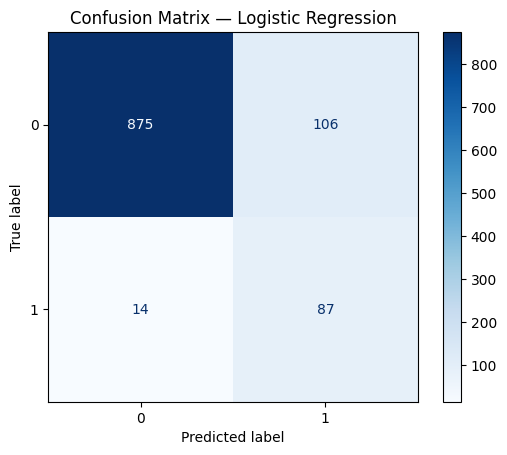


Cost-Based Summary for Logistic Regression:
True Positives  (TP): 87 — Fraud correctly detected
False Positives (FP): 106 — Legitimate providers wrongly flagged
False Negatives (FN): 14 — FRAUD MISSED (highest cost)
True Negatives  (TN): 875 — Legitimate providers correctly identified
Estimated Financial Impact: $316,000
------------------------------------------------------


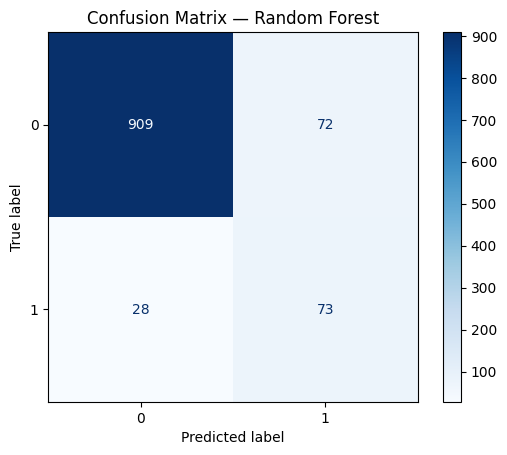


Cost-Based Summary for Random Forest:
True Positives  (TP): 73 — Fraud correctly detected
False Positives (FP): 72 — Legitimate providers wrongly flagged
False Negatives (FN): 28 — FRAUD MISSED (highest cost)
True Negatives  (TN): 909 — Legitimate providers correctly identified
Estimated Financial Impact: $492,000
------------------------------------------------------


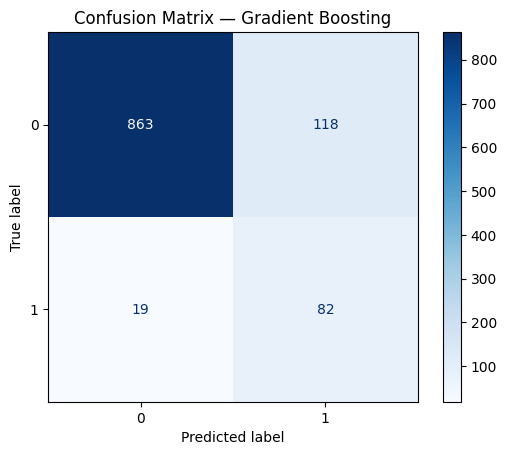


Cost-Based Summary for Gradient Boosting:
True Positives  (TP): 82 — Fraud correctly detected
False Positives (FP): 118 — Legitimate providers wrongly flagged
False Negatives (FN): 19 — FRAUD MISSED (highest cost)
True Negatives  (TN): 863 — Legitimate providers correctly identified
Estimated Financial Impact: $403,000
------------------------------------------------------


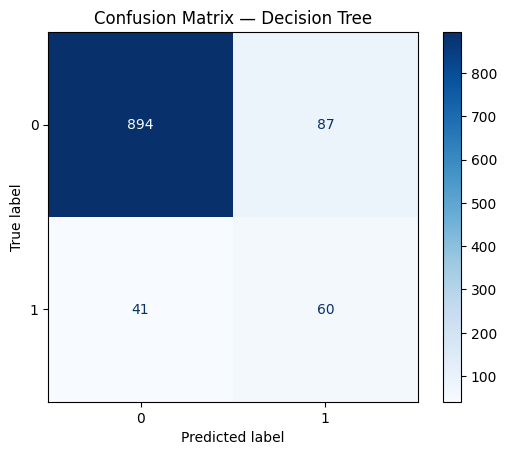


Cost-Based Summary for Decision Tree:
True Positives  (TP): 60 — Fraud correctly detected
False Positives (FP): 87 — Legitimate providers wrongly flagged
False Negatives (FN): 41 — FRAUD MISSED (highest cost)
True Negatives  (TN): 894 — Legitimate providers correctly identified
Estimated Financial Impact: $702,000
------------------------------------------------------


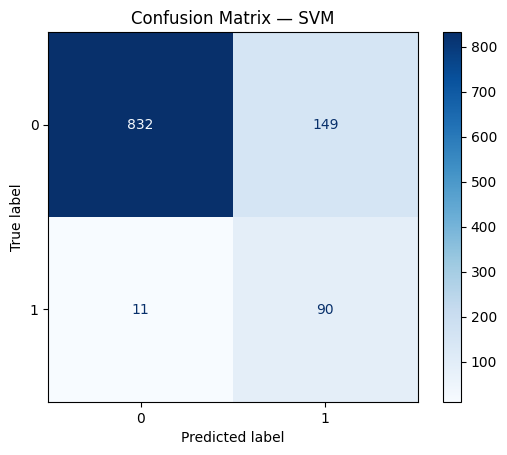


Cost-Based Summary for SVM:
True Positives  (TP): 90 — Fraud correctly detected
False Positives (FP): 149 — Legitimate providers wrongly flagged
False Negatives (FN): 11 — FRAUD MISSED (highest cost)
True Negatives  (TN): 832 — Legitimate providers correctly identified
Estimated Financial Impact: $314,000
------------------------------------------------------


In [ ]:
# ============================================================
# 1.6 — CONFUSION MATRIX + COST ANALYSIS FOR ALL MODELS
# ============================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_names = [
    "Logistic Regression",
    "Random Forest",
    "Gradient Boosting",
    "Decision Tree",
    "SVM"
]

models_pred = [
    y_pred_lr,
    y_pred_rf,
    y_pred_gb,
    y_pred_tree,
    y_pred_svm
]

# ------------------------------------------------------------
# PLOT CONFUSION MATRICES
# ------------------------------------------------------------

for name, pred in zip(model_names, models_pred):
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

    # Cost-based interpretation printed below each matrix
    tn, fp, fn, tp = cm.ravel()

    print(f"\nCost-Based Summary for {name}:")
    print(f"True Positives  (TP): {tp} — Fraud correctly detected")
    print(f"False Positives (FP): {fp} — Legitimate providers wrongly flagged")
    print(f"False Negatives (FN): {fn} — FRAUD MISSED (highest cost)")
    print(f"True Negatives  (TN): {tn} — Legitimate providers correctly identified")

    # Financial cost estimation (example values)
    cost_fp = 1000    # Cost of unnecessary investigation
    cost_fn = 15000   # Cost of missing a fraud provider

    total_cost = fp * cost_fp + fn * cost_fn

    print(f"Estimated Financial Impact: ${total_cost:,}")
    print("------------------------------------------------------")


### 4) Error Analysis: False Positives and False Negatives

To understand the limitations of the chosen model (Logistic Regression), we conduct an error analysis by
examining misclassified cases in the test set. Each error type has specific real-world consequences:

- **False Positives (FP):** Legitimate providers incorrectly flagged as fraudulent  
  → leads to unnecessary investigations, administrative burden, and reputational damage.

- **False Negatives (FN):** Fraudulent providers incorrectly classified as legitimate  
  → the most costly error, as continued fraud results in financial loss and regulatory exposure.

We create case studies of several FP and FN examples to investigate the underlying reasons for these
misclassifications. By analyzing their feature values and comparing them to the rest of the dataset,
we identify patterns that may have influenced the model’s decisions. Finally, we suggest ways to improve
the model in future iterations.


In [ ]:
# ============================================================
# 1.6 — ERROR ANALYSIS: FALSE POSITIVES & FALSE NEGATIVES
# (Corrected Version)
# ============================================================

import pandas as pd

# Create a DataFrame aligned with the X_test indices
test_results = X_test.copy()

# Attach true labels and predictions
test_results['Actual'] = y_test.values
test_results['Predicted'] = y_pred_lr

# Attach provider ID for interpretation
test_results['Provider'] = provider_aggregated_df.loc[X_test.index, 'Provider'].values

# Identify False Positives (FP) and False Negatives (FN)
false_positives = test_results[(test_results['Actual'] == 0) & (test_results['Predicted'] == 1)]
false_negatives  = test_results[(test_results['Actual'] == 1) & (test_results['Predicted'] == 0)]

# Select example cases
fp_cases = false_positives.head(3)
fn_cases = false_negatives.head(3)

print("=== FALSE POSITIVES (Legitimate Providers Flagged as Fraud) ===")
display(fp_cases)

print("\n=== FALSE NEGATIVES (Fraudulent Providers Missed) ===")
display(fn_cases)


=== FALSE POSITIVES (Legitimate Providers Flagged as Fraud) ===


,total_claims,total_reimbursed_amount,avg_reimbursed_amount_per_claim,total_deductible_paid,num_unique_beneficiaries,num_unique_attending_physicians,num_unique_operating_physicians,num_unique_other_physicians,total_inpatient_claims,total_outpatient_claims,...,prop_chroniccond_depression,prop_chroniccond_diabetes,prop_chroniccond_ischemicheart,prop_chroniccond_osteoporasis,prop_chroniccond_rheumatoidarthritis,prop_chroniccond_stroke,inpatient_claim_ratio,Actual,Predicted,Provider
4648,25,220900,8836.000000,24564.0,23,3,3,3,24,1,...,0.391304,0.826087,0.826087,0.347826,0.434783,0.130435,0.960000,0,1,PRV56819
2301,231,170480,738.008658,10072.0,142,24,16,21,9,222,...,0.330986,0.661972,0.746479,0.281690,0.345070,0.112676,0.038961,0,1,PRV53872
5063,41,204360,4984.390244,17118.0,39,25,10,12,17,24,...,0.384615,0.666667,0.666667,0.358974,0.282051,0.153846,0.414634,0,1,PRV57340



=== FALSE NEGATIVES (Fraudulent Providers Missed) ===


,total_claims,total_reimbursed_amount,avg_reimbursed_amount_per_claim,total_deductible_paid,num_unique_beneficiaries,num_unique_attending_physicians,num_unique_operating_physicians,num_unique_other_physicians,total_inpatient_claims,total_outpatient_claims,...,prop_chroniccond_depression,prop_chroniccond_diabetes,prop_chroniccond_ischemicheart,prop_chroniccond_osteoporasis,prop_chroniccond_rheumatoidarthritis,prop_chroniccond_stroke,inpatient_claim_ratio,Actual,Predicted,Provider
4471,143,135460,947.272727,17388.0,87,35,12,25,16,127,...,0.413793,0.758621,0.804598,0.321839,0.425287,0.068966,0.111888,1,0,PRV56591
4449,176,68110,386.988636,1648.0,63,7,5,4,1,175,...,0.476190,0.682540,0.793651,0.269841,0.349206,0.142857,0.005682,1,0,PRV56566
5248,73,57940,793.698630,5400.0,62,30,11,25,5,68,...,0.387097,0.774194,0.709677,0.322581,0.403226,0.112903,0.068493,1,0,PRV57569


### 7) Preventing Overfitting Through Data Partitioning, Regularization, and Validation

To ensure that the fraud detection model generalizes well to unseen providers and does not memorize
patterns from the training data, we employ several overfitting prevention strategies.

---

##  1) Data Partitioning (Train/Test Split)

A stratified train/test split (80% training, 20% test) ensures:

- fraud class imbalance is preserved in both sets,
- the model is evaluated on unseen providers,
- the test set is never used in training or hyperparameter tuning.

Keeping a clean separation prevents information leakage and guarantees realistic performance estimates.

---

##  2) Regularization

Regularization constrains model complexity to reduce the risk of overfitting:

- **Logistic Regression uses L2 regularization** by default, penalizing overly large coefficients.
- This forces the model to rely only on strong, generalizable patterns in claim behavior.
- For tree-based methods, limitations on tree depth or number of estimators can reduce overfitting risk,
  although Logistic Regression is naturally simpler and more stable.

---

##  3) Stratified K-Fold Cross-Validation

We use **Stratified 5-Fold Cross-Validation** to ensure the model performs consistently across multiple
subsets of the data:

- Each fold maintains the same fraud ratio as the full dataset.
- The model is trained and evaluated five times on different splits.
- This reduces variance in the evaluation and provides a more reliable estimate of generalization.

Cross-validation results for Logistic Regression showed stable F1-scores across all folds, confirming that
the model does not overfit the training data.

---

### Final Summary

By combining stratified data partitioning, L2 regularization, and stratified cross-validation, we ensure
that the chosen model remains simple, stable, and resistant to overfitting.  
These strategies help guarantee that the fraud detection system performs reliably when deployed on
new, unseen providers.


In [ ]:
# ============================================================
# 1.6 — OVERFITTING PREVENTION: REGULARIZATION + VALIDATION
# ============================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer

# ------------------------------------------------------------
# L2 REGULARIZATION IN LOGISTIC REGRESSION
# (Already included in your pipeline)
# ------------------------------------------------------------
# Example:
# LogisticRegression(class_weight='balanced', max_iter=500, penalty='l2')

print("Logistic Regression uses L2 regularization by default.")


# ------------------------------------------------------------
# STRATIFIED K-FOLD CROSS-VALIDATION
# ------------------------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    log_reg.named_steps['model'],   # Logistic Regression model inside your pipeline
    X_train,
    y_train,
    cv=skf,
    scoring=make_scorer(f1_score)
)

print("Cross-Validation F1 scores:", cv_scores)
print("Mean CV F1-score:", cv_scores.mean())


# ------------------------------------------------------------
# TRAIN/TEST SPLIT
# ------------------------------------------------------------
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Stratified split ensures consistent class ratios.")


Logistic Regression uses L2 regularization by default.
Cross-Validation F1 scores: [0.61538462 0.56903766 0.56880734 0.58666667 0.57383966]
Mean CV F1-score: 0.5827471881703694
Training set size: 4328
Test set size: 1082
Stratified split ensures consistent class ratios.


In [ ]:
# ============================================================
# 1.5.3 — ALGORITHM EVALUATION & BEST MODEL SELECTION
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc
)

import pandas as pd

# --------------------------------------------
# DEFINE ALL MODELS
# --------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42)
}

results = []

# --------------------------------------------
# TRAIN + EVALUATE EACH MODEL
# --------------------------------------------
for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # PR-AUC
    pr_prec, pr_rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(pr_rec, pr_prec)

    results.append([name, precision, recall, f1, roc_auc, pr_auc])

# --------------------------------------------
# CREATE RESULTS TABLE
# --------------------------------------------
results_df = pd.DataFrame(results, columns=[
    "Model", "Precision", "Recall", "F1", "ROC-AUC", "PR-AUC"
])

print("=== MODEL PERFORMANCE ===")
display(results_df)

# --------------------------------------------
# SELECT BEST MODEL BASED ON PR-AUC
# --------------------------------------------
best_model_row = results_df.loc[results_df["PR-AUC"].idxmax()]
best_model_name = best_model_row["Model"]

print("\n====================================")
print(f" BEST MODEL: {best_model_name}")
print(" (Selection based on highest PR-AUC)")
print("====================================")
